**Título do projeto:** Fatores Influenciadores nas Avaliações de Produtos

**Problema de Negócio:** A Amazon precisa entender os fatores que influenciam as pontuações e classificações dos produtos para melhorar a satisfação do cliente e aumentar as vendas

**Variáveis Consideradas:**

-Percentual de desconto (discount_price)


-Avaliação do cliente (score_sentimento)


-Contagem de avaliações (rating_count)


-Produtos com imagem no site (img_link)

# Análise de Sentimento

Dentro do campo do Processamento de Linguagem Natural (PLN), esta técnica envolve a identificação e extração de informações subjetivas em textos. O principal objetivo é determinar se o sentimento expresso em um texto é positivo, negativo ou neutro. No caso deste projeto, serve para analisar opiniões de consumidores sobre produtos da Amazon.

Neste trabalho será utilizada a biblioteca Natural Language Toolkit (NLTK), que tem um módulo chamado VADER (Valence Aware Dictionary and Sentiment Reasoner) que é bom para análises de sentimento em textos.

In [2]:
# Instalação para ter interface com o bigquery

!pip install google-cloud-bigquery
!pip install langdetect
!pip install textblob
!pip install unidecode
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=892c4cba2764aa81135bc853c76c3a00049ced7351145075f9fd380edb85903e
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.0 MB/s eta 0:00:00


In [3]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd
import re
from langdetect import detect
import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

In [4]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

# Configurar o cliente BigQuery
project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

# Query para pegar os dados do BigQuery
query = """
SELECT product_id, review_content
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query
query_job = client.query(query)
results = query_job.result()

# Criando um Dataframe
df = pd.DataFrame([dict(row) for row in results])

# Convertendo para string
df['review_content'] = df['review_content'].astype(str)

# Detectar idioma antes de limpar o texto
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

# Aplicar a detecção de linguagem e filtrar para apenas reviews em inglês
df = df[df['review_content'].apply(detect_language) == 'en']

# Limpar texto
def clean_text(text):
    # Adicionar espaço após cada vírgula
    text = re.sub(r',', ', ', text)

    # Remover links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remover datas
    text = re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', '', text)

    # Remover valores monetários
    text = re.sub(r'\$\d+(?:\.\d+)?|\d+(?:\.\d+)?\s?USD', '', text)

    # Remover valores numéricos
    text = re.sub(r'\b\d+\b', '', text)

    # Remover caracteres especiais
    text = re.sub(r'[^\w\s]', '', text)

    # Converter letras para minúsculo
    text = text.lower()

    # Remover acentos
    text = unidecode.unidecode(text)

    # Remover stop words (palavras comuns que não carregam muito significado, como "and", "the", etc.)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Aplicando lematização, que reduz palavras à sua forma básica.
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

# Aplicar a função de limpeza à coluna 'review_content'
df['review_limpo'] = df['review_content'].apply(clean_text)

# Inicializar o SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Aplicar a análise de sentimento à coluna 'review_limpo'
df['score_sentimento'] = df['review_limpo'].apply(analyze_sentiment)

# Carregar DataFrame com as novas colunas ao BigQuery em uma nova tabela
new_table_id = "datalab-amazon-produtos.amazon_sales.amazon_sentimento"
df[['product_id', 'score_sentimento']].to_gbq(destination_table=new_table_id, project_id=project_id, if_exists='replace')

# Exibir dataframe
df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
100%|██████████| 1/1 [00:00<00:00, 732.37it/s]


,product_id,review_content,review_limpo,score_sentimento
0,B0BPJBTB3F,The heating capacity is zero Moreover i have i...,heating capacity zero moreover initiated retur...,0.7717
1,B09F6D21BY,The mouse feature of the remote is not working...,mouse feature remote workingremote control pus...,0.3818
2,B08YK7BBD2,Hi viewers so I bought this product after watc...,hi viewer bought product watching endless haul...,0.8920
3,B0B82YGCF6,Its is value for moneyGood productGood likedch...,value moneygood productgood likedcharging last...,0.9062
4,B0B94JPY2N,I have a pd supported car charger and I bought...,pd supported car charger bought solimo cable p...,0.8555


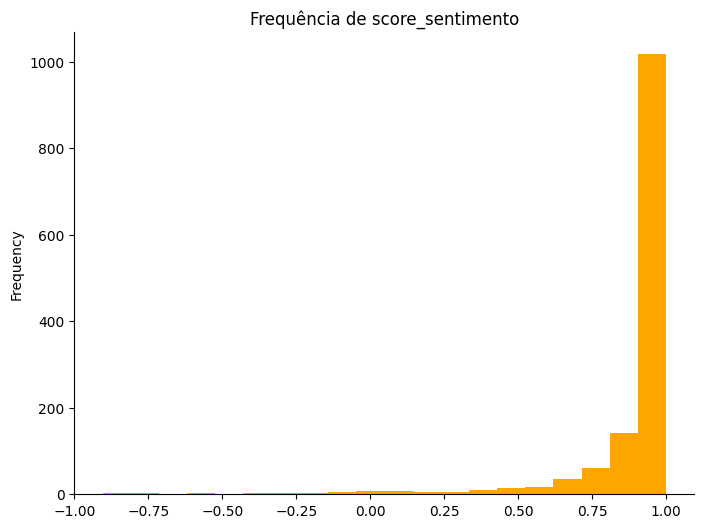

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df['score_sentimento'], bins=20, color='orange')
plt.title('Frequência de score_sentimento')
plt.ylabel('Frequency')  # Adiciona o rótulo "Frequency" no eixo y
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()



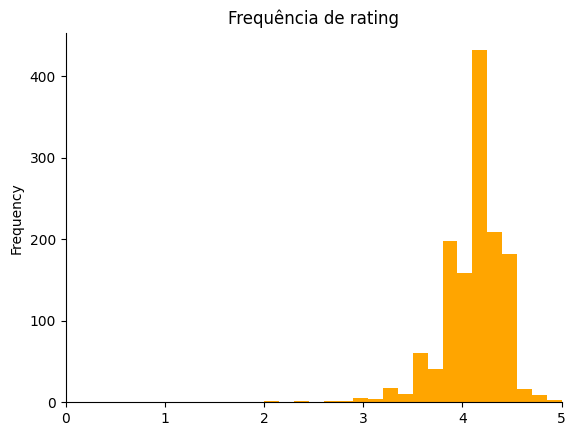

In [ ]:
# Gráfico da frequência da avaliação do cliente (rating)

query = """
SELECT
  product_id,
  score_sentimento,
  SAFE_CAST(rating AS FLOAT64) AS rating
FROM
  `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""
# Executar a query
query_job = client.query(query)
results = query_job.result()

# Criando um Dataframe
df = pd.DataFrame([dict(row) for row in results])

from matplotlib import pyplot as plt

# Configurações do gráfico
plt.figure
df['rating'].plot(kind='hist', bins=20, title='Frequência de rating', color='orange')  # Define a cor do histograma como laranja
plt.gca().spines[['top', 'right']].set_visible(False)  # Remove as bordas superior e direita
plt.xlim(0, 5)  # Define os limites do eixo x
plt.show()


# Wordcloud

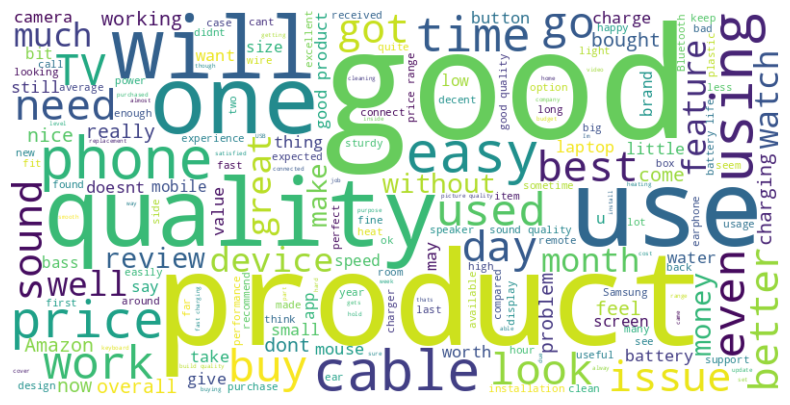

In [ ]:
# Importar as bibliotecas necessárias
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from google.cloud import bigquery
import pandas as pd

# Definir o projeto do BigQuery
project_id = "datalab-amazon-produtos"

# Criar o cliente BigQuery
client = bigquery.Client(project=project_id)

# Consulta SQL para obter os dados
query = """
SELECT review_content
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query
query_job = client.query(query)
results = query_job.result()

# Criar um DataFrame com os resultados da consulta
df = pd.DataFrame([dict(row) for row in results])

# Concatenar todas as strings da coluna 'review_content' em uma única string
text = ' '.join(df['review_content'].tolist())

# Gerar a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Exibir a word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#Análise Exploratória

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT *
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.DataFrame([dict(row) for row in results])

df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1350 entries, 0 to 1350
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1350 non-null   object 
 1   product_name         1350 non-null   object 
 2   category             1350 non-null   object 
 3   discounted_price     1350 non-null   float64
 4   actual_price         1350 non-null   float64
 5   discount_percentage  1350 non-null   float64
 6   about_product        1350 non-null   object 
 7   user_id              1350 non-null   object 
 8   user_name            1350 non-null   object 
 9   review_id            1350 non-null   object 
 10  review_title         1350 non-null   object 
 11  review_content       1350 non-null   object 
 12  img_link             891 non-null    object 
 13  product_link         891 non-null    object 
 14  rating               1350 non-null   float64
 15  rating_count         1350 non-null   int64 

In [ ]:
df.describe()

,discounted_price,actual_price,discount_percentage,rating,rating_count,img_link_dummy,product_link_dummy,score_sentimento
count,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,3305.703089,5692.874533,0.467015,4.091852,17637.676296,0.660000,0.660000,0.883935
std,7176.565121,11222.739126,0.216130,0.297444,42130.522394,0.473884,0.473884,0.246048
min,39.000000,39.000000,0.000000,2.000000,2.000000,0.000000,0.000000,-0.904800
25%,349.000000,899.000000,0.310000,3.900000,1110.500000,0.000000,0.000000,0.906200
50%,896.000000,1782.500000,0.490000,4.100000,4738.000000,1.000000,1.000000,0.965600
75%,2176.500000,4582.500000,0.620000,4.300000,16007.500000,1.000000,1.000000,0.987100
max,77990.000000,139900.000000,0.940000,5.000000,426973.000000,1.000000,1.000000,0.999800


In [ ]:
# Média, mediana, desvio padrão, máximos e mínimos

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT *
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.DataFrame([dict(row) for row in results])
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating'])

numeric_df = df.select_dtypes(include=['float64', 'int64'])

summary = numeric_df.agg(['mean', 'median', 'std', 'min', 'max'])

summary = summary.round(2)

print(summary)

        discounted_price  actual_price  discount_percentage  rating  \
mean             3305.70       5692.87                 0.47    4.09   
median            896.00       1782.50                 0.49    4.10   
std              7176.57      11222.74                 0.22    0.30   
min                39.00         39.00                 0.00    2.00   
max             77990.00     139900.00                 0.94    5.00   

        rating_count  img_link_dummy  product_link_dummy  score_sentimento  
mean        17637.68            0.66                0.66              0.88  
median       4738.00            1.00                1.00              0.97  
std         42130.52            0.47                0.47              0.25  
min             2.00            0.00                0.00             -0.90  
max        426973.00            1.00                1.00              1.00  


#Matriz de Correlação

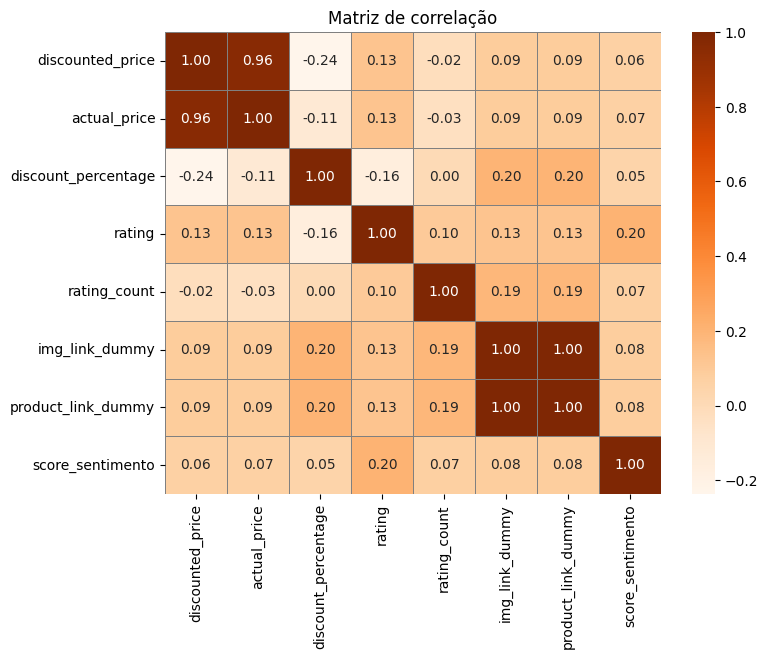

In [ ]:
import seaborn as sns

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT *
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.DataFrame([dict(row) for row in results])
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating'])

numerical_df = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Oranges', fmt=".2f",
            linewidths=.5, linecolor='gray')
plt.title('Matriz de correlação')
plt.show()


In [ ]:
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

# Calcular a mediana
median_query = """
SELECT
  APPROX_QUANTILES(rating, 2)[OFFSET(1)] AS median_rating
FROM
  `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

query_job = client.query(median_query)
results = query_job.result()

median_rating = list(results)[0]['median_rating']

# Atualizar valores nulos
update_query = f"""
UPDATE
  `datalab-amazon-produtos.amazon_sales.amazon_completa`
SET
  rating = {median_rating}
WHERE
  rating IS NULL;
"""

query_job = client.query(update_query)
query_job.result()  # Espera até que a query termine
print("Valores nulos foram substituídos pela mediana.")


**Identificando a classificação por categoria de produto**

       category  rating
0   electronics     3.0
1   electronics     3.0
2   electronics     2.8
3   electronics     3.2
4  home kitchen     2.3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  1351 non-null   object 
 1   rating    1350 non-null   float64
dtypes: float64(1), object(1)
memory usage: 21.2+ KB
None
       category  rating
0   electronics     3.0
1   electronics     3.0
2   electronics     2.8
3   electronics     3.2
4  home kitchen     2.3
<class 'pandas.core.frame.DataFrame'>
Index: 1350 entries, 0 to 1350
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  1350 non-null   object 
 1   rating    1350 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.6+ KB
None


<ipython-input-5-e20a3a1d2394>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='category', data=df, orient='h', palette=["#FFA500"])
<ipython-input-5-e20a3a1d2394>:45: UserWarning: 
The palette list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='rating', y='category', data=df, orient='h', palette=["#FFA500"])


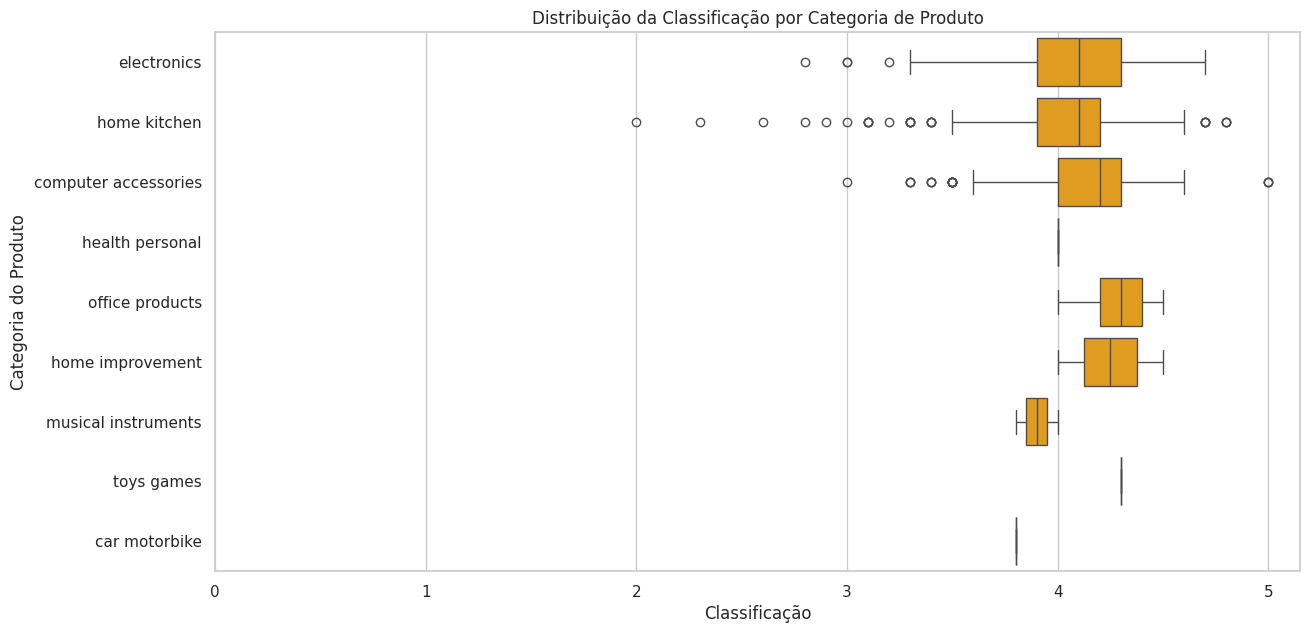

In [ ]:
!pip install seaborn matplotlib pandas

# Importar bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import auth
from google.cloud import bigquery

# Autenticar e configurar o cliente BigQuery
auth.authenticate_user()
project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

# Consultar os dados
query = """
SELECT category, rating
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a consulta e carregar os dados em um DataFrame
query_job = client.query(query)
results = query_job.result()
df = pd.DataFrame([dict(row) for row in results])

# Verificar os dados
print(df.head())
print(df.info())

df['rating'] = df['rating'].replace('', pd.NA)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Remover linhas com valores nulos em 'rating'
df = df.dropna(subset=['rating'])

# Verificar novamente os dados após limpeza
print(df.head())
print(df.info())

# Configurar o estilo dos gráficos
sns.set(style="whitegrid")

# Criar o gráfico de boxplot para 'rating' por 'category_limpa'
plt.figure(figsize=(14, 7))
sns.boxplot(x='rating', y='category', data=df, orient='h', palette=["#FFA500"])

# Ajustar os ticks do eixo X para mostrar valores inteiros de 0 a 5
plt.xticks(ticks=[0, 1, 2, 3, 4, 5])

plt.title('Distribuição da Classificação por Categoria de Produto')
plt.xlabel('Classificação')
plt.ylabel('Categoria do Produto')
plt.show()


#  Produtos com maiores e menores preços

Verificando os produtos com maiores e menores preços dentro de cada categoria, bem como o valor médio.

In [10]:
import pandas as pd
from google.colab import auth
from google.cloud import bigquery

# Autenticar e configurar o cliente BigQuery
auth.authenticate_user()
project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

# Consultar os dados
query = """
SELECT category, actual_price, product_name
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a consulta e carregar os dados em um DataFrame
query_job = client.query(query)
results = query_job.result()
df = pd.DataFrame([dict(row) for row in results])

# Agrupar e agregar os dados
agg_df = df.groupby('category').agg(
    preco_medio=('actual_price', 'mean'),
    preco_minimo=('actual_price', 'min'),
    preco_maximo=('actual_price', 'max')
).reset_index()

# Identificar os produtos com o menor e maior preço dentro de cada categoria
min_price_product = df.loc[df.groupby('category')['actual_price'].idxmin()]
min_price_product = min_price_product[['category', 'product_name', 'actual_price']]
min_price_product.columns = ['category', 'produto_menor_preço', 'preço_menor']

max_price_product = df.loc[df.groupby('category')['actual_price'].idxmax()]
max_price_product = max_price_product[['category', 'product_name', 'actual_price']]
max_price_product.columns = ['category', 'produto_maior_preço', 'preço_maior']

# Mesclar os DataFrames
final_df = pd.merge(agg_df, min_price_product, on='category')
final_df = pd.merge(final_df, max_price_product, on='category')

# Exibir a tabela no Jupyter Notebook ou Google Colab
final_df

,category,preco_medio,preco_minimo,preco_maximo,produto_menor_preço,preço_menor,produto_maior_preço,preço_maior
0,car motorbike,4000.000000,4000.0,4000.0,Reffair AX30 MAX Portable Air Purifier for Car...,4000.0,Reffair AX30 MAX Portable Air Purifier for Car...,4000.0
1,computer accessories,1855.345653,39.0,59890.0,ECOSMOS 5V 12W Portable Flexible USB LED Light...,39.0,Lenovo IdeaPad 3 11th Gen Intel Core i3 156 FH...,59890.0
2,electronics,10418.083673,171.0,139900.0,Goldmedal Curve Plus 202042 Plastic Spice 3Pin...,171.0,Sony Bravia 164 cm 65 inches 4K Ultra HD Smart...,139900.0
3,health personal,1900.000000,1900.0,1900.0,Dr Trust Electronic Kitchen Digital Scale Weig...,1900.0,Dr Trust Electronic Kitchen Digital Scale Weig...,1900.0
4,home improvement,799.000000,599.0,999.0,Gizga Essentials Cable Organiser Cord Manageme...,599.0,ESnipe Mart Worldwide Travel Adapter with Buil...,999.0
5,home kitchen,4162.073661,79.0,75990.0,Kitchenwell 18Pc Plastic Food Snack Bag Pouch ...,79.0,LG 15 Ton 5 Star AI DUAL Inverter Split AC Cop...,75990.0
6,musical instruments,1347.000000,699.0,1995.0,MAONO AU400 Lavalier Auxiliary Omnidirectional...,699.0,Boya ByM1 Auxiliary Omnidirectional Lavalier C...,1995.0
7,office products,397.193548,50.0,2999.0,Classmate Octane Neon Blue Gel PensPack of 5Sm...,50.0,Portronics Ruffpad 15 ReWritable LCD Screen 38...,2999.0
8,toys games,150.000000,150.0,150.0,FaberCastell Connector Pen Set Pack of 25 Ass...,150.0,FaberCastell Connector Pen Set Pack of 25 Ass...,150.0


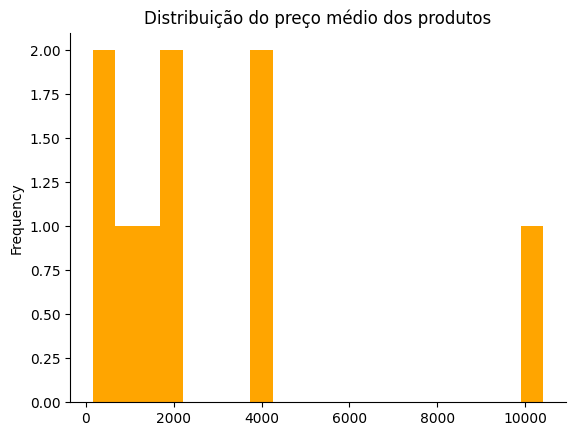

In [12]:
# @title preco_medio

from matplotlib import pyplot as plt
final_df['preco_medio'].plot(kind='hist', bins=20, color= 'orange', title='Distribuição do preço médio dos produtos')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Teste de Hipótese

* Hipótese 1: produtos com maior desconto aplicado (discount_percentage) são melhor classificados (rating);

* Hipótese 2: produtos com mais avaliações positivas (score_sentimento) são melhor classificados (rating);

* Hipótese 3: produtos com mais avaliações (rating_count) são melhores classificados (rating);

#Hipótese 1

Produtos com maior desconto aplicado (discount_percentage) são melhor classificados (rating)

Teste de Shapiro Wilk para testar a normalidade dos dados (Hipótese 1)

In [ ]:
import pandas as pd
from scipy.stats import shapiro
from google.colab import auth
from google.cloud import bigquery

# Autenticação
auth.authenticate_user()

# Definir o projeto do BigQuery
project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

# Definir a consulta
query = """
SELECT discount_percentage, rating
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a consulta e carregar os dados em um DataFrame
query_job = client.query(query)
results = query_job.result()
df = pd.DataFrame([dict(row) for row in results])

# Verificar os dados
print(df.head())
print(df.info())

# Separar os dados em duas variáveis diferentes
dados_desconto = df['discount_percentage'].dropna()
dados_rating = df['rating'].dropna()

# Shapiro para discount_percentage
estatistica_shapiro_desconto, p_valor_desconto = shapiro(dados_desconto)

# Printar os resultados para discount_percentage
print(f'Estatísticas de Shapiro para discount_percentage: {estatistica_shapiro_desconto}')
print(f'P-valor para discount_percentage: {p_valor_desconto}')

# Shapiro para rating
estatistica_shapiro_rating, p_valor_rating = shapiro(dados_rating)

# Printar os resultados para rating
print(f'Estatísticas de Shapiro para rating: {estatistica_shapiro_rating}')
print(f'P-valor para rating: {p_valor_rating}')

# Interpretando os resultados para discount_percentage
alpha = 0.05
if p_valor_desconto > alpha:
    print('Os dados de discount_percentage parecem seguir uma distribuição normal.')
else:
    print('Os dados de discount_percentage parecem não seguir uma distribuição normal.')

# Interpretando os resultados para rating
if p_valor_rating > alpha:
    print('Os dados de rating parecem seguir uma distribuição normal.')
else:
    print('Os dados de rating parecem não seguir uma distribuição normal.')


   discount_percentage  rating
0                 0.60     3.0
1                 0.74     3.0
2                 0.86     2.8
3                 0.40     3.2
4                 0.55     2.3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   discount_percentage  1351 non-null   float64
 1   rating               1350 non-null   float64
dtypes: float64(2)
memory usage: 21.2 KB
None
Estatísticas de Shapiro para discount_percentage: 0.98283451795578
P-valor para discount_percentage: 1.3958163617988628e-11
Estatísticas de Shapiro para rating: 0.9262979626655579
P-valor para rating: 3.2684176237159127e-25
Os dados de discount_percentage parecem não seguir uma distribuição normal.
Os dados de rating parecem não seguir uma distribuição normal.


Histograma de desconto

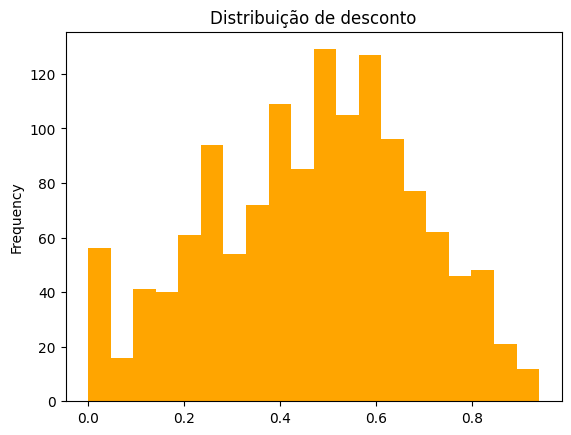

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df['discount_percentage'].plot(kind='hist', bins=20, color='orange', title='Distribuição de desconto')
plt.show()


Correlação de Sperman (pois os dados não estão normalmente distribuidos)

In [ ]:
from scipy.stats import spearmanr
import pandas as pd
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT discount_percentage, rating
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query
query_job = client.query(query)
results = query_job.result()

# Converter os resultados em um DataFrame
df = results.to_dataframe()

# Separar os dados em duas variáveis diferentes
discount_percentage = df['discount_percentage']
rating = df['rating']

# Criando um dataframe
df_cleaned = pd.DataFrame({'discount_percentage': discount_percentage, 'rating': rating})
df_cleaned = df_cleaned.dropna()  # Remover linhas com valores NaN em ambas as colunas

# Extraindo as séries limpas
discount_percentage = df_cleaned['discount_percentage']
rating = df_cleaned['rating']

# Spearman para as variáveis discount_percentage e rating
correlation, p_value = spearmanr(discount_percentage, rating)
print(f'Correlação de Spearman: {correlation}, p-value: {p_value}')

# Comparar com alpha (0.05)
alpha = 0.05
if p_value < alpha:
    print("Rejeita a hipótese nula. Há uma correlação significativa.")
else:
    print("Não há evidência suficiente para rejeitar a hipótese nula, ou seja, não há uma correlação significativa.")


Correlação de Spearman: -0.1495078602575248, p-value: 3.404907464646723e-08
Rejeita a hipótese nula. Há uma correlação significativa.


O valor da correlação é -0.1495, indicando uma correlação negativa fraca entre a classificação ("rating") e o percentual de desconto ("discount_percentage"). Isso sugere que, de maneira geral, produtos com maior desconto tendem a ter uma classificação ligeiramente mais baixa, mas a relação é fraca. O p-valor é muito pequeno (menor que 0.05), o que indica que a correlação observada é estatisticamente significativa. Portanto, rejeitamos a hipótese nula de que não há correlação entre as duas variáveis e concluímos que há uma correlação significativa, mesmo que fraca.

Teste de significância para a hipótese 1

O teste de Mann-Whitney mostra que existe uma diferença significativa entre os grupos "alto" e "baixo" de percentual de desconto. Isso implica que a distribuição das classificações é diferente entre os dois grupos, e essa diferença é estatisticamente significativa.

In [13]:
import pandas as pd
from scipy.stats import mannwhitneyu
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT discount_percentage, rating
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query
query_job = client.query(query)
results = query_job.result()

# Converter os resultados em um DataFrame
df = results.to_dataframe()

# Definindo um ponto de corte para alta e baixa porcentagem de desconto (0.50)
alta_group = df[df['discount_percentage'] > 0.5]['rating']
baixa_group = df[df['discount_percentage'] <= 0.5]['rating']

# Execute o teste de Mann-Whitney U
estatistica, p_value = mannwhitneyu(alta_group, baixa_group, alternative='two-sided')

# Imprima os resultados
print(f"Mann-Whitney U statistic: {estatistica:.4f}")
print(f"P-value: {p_value:.4f}")

# Verifique se o p-value é significativo (por exemplo, menor que 0.05)
if p_value < 0.05:
    print("A diferença entre os grupos 'alto' e 'baixo' do percentual de desconto é estatisticamente significativo.")
else:
    print("Não há diferença estatisticamente significativa entre os grupos 'alto' e 'baixo' do percentual de desconto.")

Mann-Whitney U statistic: 196273.5000
P-value: 0.0000
A diferença entre os grupos 'alto' e 'baixo' do percentual de desconto é estatisticamente significativo.


Regressão linear para a hipótese 1

O R² indica que apenas 2.2% da variação na variável dependente (rating) é explicada pelo modelo. Este é um valor bastante baixo, sugerindo que o modelo explica muito pouco da variação na classificação dos produtos.

O modelo de regressão linear mostra que o percentual de desconto tem um impacto estatisticamente significativo sobre a classificação dos produtos, com uma correlação negativa. No entanto, o baixo valor de R² indica que o modelo não explica bem a variação na variável dependente. Isso sugere que, embora o desconto tenha um efeito significativo, há muitos outros fatores que também influenciam a classificação dos produtos e que não estão sendo considerados neste modelo.

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     24.70
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           7.79e-07
Time:                        19:35:53   Log-Likelihood:                -236.33
No. Observations:                1080   AIC:                             476.7
Df Residuals:                    1078   BIC:                             486.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.1848    

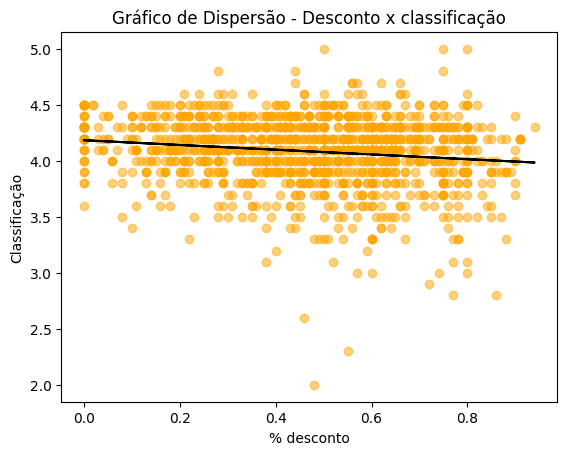

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

df = df.dropna(subset=['discount_percentage', 'rating'])

# Selecionar as variáveis independentes (X) e dependente (y)
X = df[['discount_percentage']]  # Variável independente
y = df['rating']  # Variável dependente

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Adicionar uma constante ao X (intercepto)
X_train_sm = sm.add_constant(X_train)

# Ajustar o modelo de regressão linear
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Printar o sumário do modelo
print(model_sm.summary())

# Plotar o gráfico de dispersão
plt.scatter(df['discount_percentage'], df['rating'], alpha=0.5, color='orange')
plt.title('Gráfico de Dispersão - Desconto x classificação')
plt.xlabel('% desconto')
plt.ylabel('Classificação')
plt.plot(df['discount_percentage'], model.predict(X), color='black')
plt.show()

#Hipótese 2

Produtos com mais avaliações positivas (score_sentimento) são melhor classificados (rating);

Teste de normalidade para a hipótese 2

In [ ]:
# Shapiro-Wilk

import pandas as pd
from scipy.stats import shapiro
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT score_sentimento
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query
query_job = client.query(query)
results = query_job.result()

df = pd.read_gbq(query, project_id=project_id, dialect="standard")

dados_sentimento = df['score_sentimento']

# Remove NaN values from 'dados_sentimento'
dados_sentimento = dados_sentimento.dropna()

# Shapiro para score_sentimento
estatistica_shapiro_sentimento, p_valor_sentimento = shapiro(dados_sentimento)

# Printar os resultados para discount_percentage
print(f'Estatísticas de Shapiro para score_sentimento: {estatistica_shapiro_sentimento}')
print(f'P-valor para score_entimento: {p_valor_sentimento}')

# Interpretando os resultados para score_sentimento
alpha = 0.05
if p_valor_desconto > alpha:
    print('Os dados parecem seguir uma distribuição normal.')
else:
    print('Os dados parecem não seguir uma distribuição normal.')


Estatísticas de Shapiro para score_sentimento: 0.4656304121017456
P-valor para score_entimento: 0.0
Os dados parecem não seguir uma distribuição normal.


Correlação de Spearman

O valor de 0.2395 sugere uma correlação positiva moderada entre score_sentimento e rating. De maneira geral, quando o nível de satisfação do cliente (score_sentimento) aumenta, a classificação dos produtos (rating) também tende a aumentar. A correlação positiva indica que há uma tendência geral de que uma maior satisfação está associada a melhores classificações.

O valor p é menor que 0.05. Isso indica que a correlação observada é estatisticamente significativa.

In [ ]:
from scipy.stats import spearmanr
import pandas as pd
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT score_sentimento, rating
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query
query_job = client.query(query)
results = query_job.result()

# Converter os resultados em um DataFrame
df = results.to_dataframe()

# Separar os dados em duas variáveis diferentes
score_sentimento = df['score_sentimento']
rating = df['rating']

# Criando um dataframe
df_cleaned = pd.DataFrame({'score_sentimento': score_sentimento, 'rating': rating})
df_cleaned = df_cleaned.dropna()  # Remover linhas com valores NaN em ambas as colunas

# Extraindo as séries limpas
score_sentimento = df_cleaned['score_sentimento']
rating = df_cleaned['rating']

# Spearman para as variáveis score_sentimento e rating
correlation, p_value = spearmanr(score_sentimento, rating)
print(f'Correlação de Spearman: {correlation}, p-value: {p_value}')

# Comparar com alpha (0.05)
alpha = 0.05
if p_value < alpha:
    print("Rejeita a hipótese nula. Há uma correlação significativa.")
else:
    print("Não há evidência suficiente para rejeitar a hipótese nula, ou seja, não há uma correlação significativa.")


Correlação de Spearman: 0.23957802674649614, p-value: 4.465429567888842e-19
Rejeita a hipótese nula. Há uma correlação significativa.



Teste de significância para a hipótese 2

O valor p é > 0.05. Isso indica que na diferença entre os grupos "alto" e "baixo" do score_sentimento não é estatisticamente significativa. Em outras palavras, as classificações dos produtos não são significativamente diferentes entre os grupos de alta e baixa satisfação. Isso sugere que a satisfação do cliente não tem um impacto significativo na classificação do produto, e as diferenças observadas entre os grupos não são atribuíveis ao acaso.

In [14]:
import pandas as pd
from scipy.stats import mannwhitneyu
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT score_sentimento, rating
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query
query_job = client.query(query)
results = query_job.result()

# Converter os resultados em um DataFrame
df = results.to_dataframe()

# Definindo um ponto de corte para alta e baixa score_sentimento (0.75)
alta_group = df[df['score_sentimento'] > 0.75]['rating']
baixa_group = df[df['score_sentimento'] <= 0.75]['rating']

# Execute o teste de Mann-Whitney U
estatistica, p_value = mannwhitneyu(alta_group, baixa_group, alternative='two-sided')

# Imprima os resultados
print(f"Mann-Whitney U statistic: {estatistica:.4f}")
print(f"P-value: {p_value:.4f}")

# Verifique se o p-value é significativo (por exemplo, menor que 0.05)
if p_value < 0.05:
    print("A diferença entre os grupos 'alto' e 'baixo' do score de sentimento é estatisticamente significativo.")
else:
    print("Não há diferença estatisticamente significativa entre os grupos 'alto' e 'baixo' do score de sentimento.")

Mann-Whitney U statistic: 111864.0000
P-value: 0.0000
A diferença entre os grupos 'alto' e 'baixo' do score de sentimento é estatisticamente significativo.


Regressão Linear

Regressão linear para a hipótese 2

O R² indica que aproximadamente 4.5% da variação na variável dependente rating é explicada pelo modelo (ou seja, pela variável independente score_sentimento). Esse é um valor relativamente baixo, sugerindo que o modelo não explica muita variação na classificação dos produtos. A maioria da variação no rating não é explicada por score_sentimento, indicando que há muitos outros fatores além de score_sentimento que afetam a classificação dos produtos. O modelo é estatisticamente significativo (p: 0.000), o que indica que score_sentimento tem uma relação significativa com rating, mas o impacto explicativo geral é limitado.

Embora o score_sentimento tenha uma influência estatisticamente significativa sobre o rating, o modelo de regressão linear mostra que essa influência é relativamente pequena, explicando apenas uma pequena fração da variação na classificação dos produtos. Isso sugere que outros fatores além da satisfação do cliente também têm um impacto importante nas classificações dos produtos.

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     50.68
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           1.98e-12
Time:                        19:58:22   Log-Likelihood:                -223.75
No. Observations:                1080   AIC:                             451.5
Df Residuals:                    1078   BIC:                             461.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.8532      0.034  

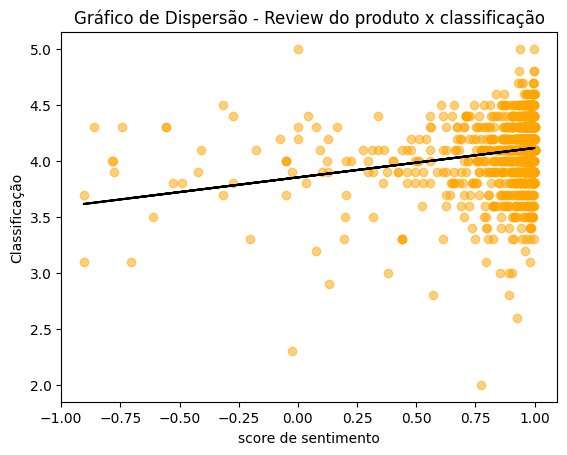

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Corrigindo rating
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['score_sentimento', 'rating'])

# Selecionar as variáveis independentes (X) e dependente (y)
X = df[['score_sentimento']]  # Variável independente
y = df['rating']  # Variável dependente

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Adicionar uma constante ao X (intercepto)
X_train_sm = sm.add_constant(X_train)

# Ajustar o modelo de regressão linear
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Printar o sumário do modelo
print(model_sm.summary())

# Plotar o gráfico de dispersão
plt.scatter(df['score_sentimento'], df['rating'], alpha=0.5, color='orange')
plt.title('Gráfico de Dispersão - Review do produto x classificação')
plt.xlabel('score de sentimento')
plt.ylabel('Classificação')
plt.plot(df['score_sentimento'], model.predict(X), color='black')
plt.show()

#Hipótese 3

Teste de normalidade para a hipótese 3

In [ ]:
import pandas as pd
from scipy.stats import shapiro
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT rating_count
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query
query_job = client.query(query)
results = query_job.result()

df = pd.read_gbq(query, project_id=project_id, dialect="standard")

dados_rating_count = df['rating_count']

# Remove NaN values from 'rating_count'
dados_rating_count = dados_rating_count.dropna()

# Shapiro para rating_count
estatistica_shapiro_rating_count, p_valor_rating_count = shapiro(dados_rating_count)

# Printar os resultados para rating_count
print(f'Estatísticas de Shapiro para rating_count: {estatistica_shapiro_rating_count}')
print(f'P-valor para rating_count: {p_valor_rating_count}')

# Interpretando os resultados para rating_count
alpha = 0.05
if p_valor_desconto > alpha:
    print('Os dados parecem seguir uma distribuição normal.')
else:
    print('Os dados parecem não seguir uma distribuição normal.')

Estatísticas de Shapiro para rating_count: 0.40636348724365234
P-valor para rating_count: 0.0
Os dados parecem não seguir uma distribuição normal.


Histograma de desconto

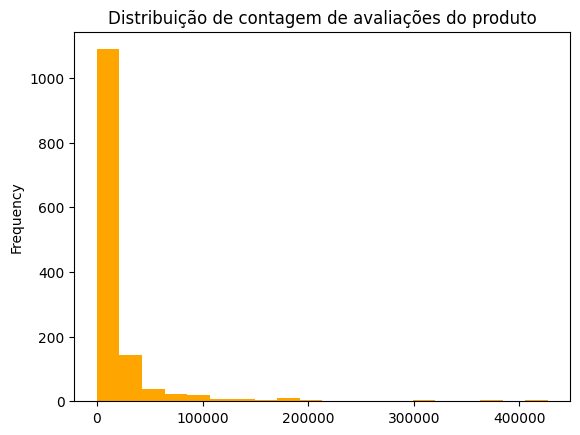

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df['rating_count'].plot(kind='hist', bins=20, color='orange', title='Distribuição de contagem de avaliações do produto')
plt.show()

Correlação de spearman

Teste de correlação para a hipótese 3

A correlação de Spearman de 0.1928 indica que há uma correlação positiva significativa entre a variável rating_count (contagem de classificações) e rating (classificação). Isso sugere que produtos com mais avaliações tendem a ter classificações mais altas.

In [ ]:
from scipy.stats import spearmanr
import pandas as pd
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT rating_count, rating
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query
query_job = client.query(query)
results = query_job.result()

df = pd.read_gbq(query, project_id=project_id, dialect="standard")

# Separar os dados em duas variáveis diferentes
score_sentimento = df['rating_count']

# Criando um dataframe
df_cleaned = pd.DataFrame({'rating_count': score_sentimento, 'rating': rating})
df_cleaned = df_cleaned.dropna()  # Remover linhas com valores NaN em mabas colunas

# Extraindo as séries limpas
rating_count = df_cleaned['rating_count']
rating = df_cleaned['rating']

# Spearman para as variáveis rating_count e rating
correlation, p_value = spearmanr(rating_count, rating)
print(f'Correlação de Spearman: {correlation}, p-value: {p_value}')

# Comparar com alpha (0.05)
alpha = 0.05
if p_value < alpha:
    print("Rejeita a hipótese nula. Há uma correlação significativa.")
else:
    print("Não há evidência suficiente para rejeitar a hipótese nula, ou seja, não há uma correlação significativa.")

Correlação de Spearman: 0.19284442155334855, p-value: 8.92311050339563e-13
Rejeita a hipótese nula. Há uma correlação significativa.


Teste de Significância

p (p-value): 0.0000, indica que a diferença entre os grupos 'alto' e 'baixo' na contagem de avaliações é estatisticamente significativa. Em outras palavras, as classificações dos produtos entre os grupos de alta e baixa contagem de avaliações são significativamente diferentes. Isso sugere que produtos com diferentes níveis de contagem de avaliações têm classificações significativamente diferentes.

In [16]:
import pandas as pd
from scipy.stats import mannwhitneyu
from google.colab import auth
from google.cloud import bigquery

# Autenticar no Google Cloud
auth.authenticate_user()

# Definir o ID do projeto do BigQuery
project_id = "datalab-amazon-produtos"

# Criar um cliente BigQuery
client = bigquery.Client(project=project_id)

# Query para selecionar rating_count e rating
query = """
SELECT rating_count, rating
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query e obter os resultados
query_job = client.query(query)
df = query_job.to_dataframe()

# Ajustando o limite para categoria alto e baixo rating_count baseado na distribuição dos dados (utilizando a mediana)
mediana = df['rating_count'].median()

# Criar grupos baseados na mediana
alta_group = df[df['rating_count'] > mediana]['rating']
baixa_group = df[df['rating_count'] <= mediana]['rating']

# Executar o teste de Mann-Whitney U
estatistica, p_value = mannwhitneyu(alta_group, baixa_group, alternative='two-sided')

# Imprimir os resultados
print(f"Mann-Whitney U statistic: {estatistica:.4f}")
print(f"P-value: {p_value:.4f}")

# Verificar se o p-value é significativo (por exemplo, menor que 0.05)
if p_value < 0.05:
    print("A diferença entre os grupos 'alto' e 'baixo' da contagem de classificações é estatisticamente significativa.")
else:
    print("Não há diferença estatisticamente significativa entre os grupos 'alto' e 'baixo' da contagem de classificações.")


Mann-Whitney U statistic: 271736.5000
P-value: 0.0000
A diferença entre os grupos 'alto' e 'baixo' da contagem de classificações é estatisticamente significativa.


Regressão Linear

<class 'pandas.core.frame.DataFrame'>
Index: 1350 entries, 1 to 1350
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rating_count  1350 non-null   int64  
 1   rating        1350 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.6 KB
None
   rating_count  rating
1           111     3.1
2           109     2.8
3             2     2.0
4           617     3.0
5           113     3.2
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     10.08
Date:                Fri, 12 Jul 2024   Prob (F-statistic):            0.00154
Time:                        20:12:10   Log-Likelihood:                -243.53
No. Observations:                1080   AIC:         

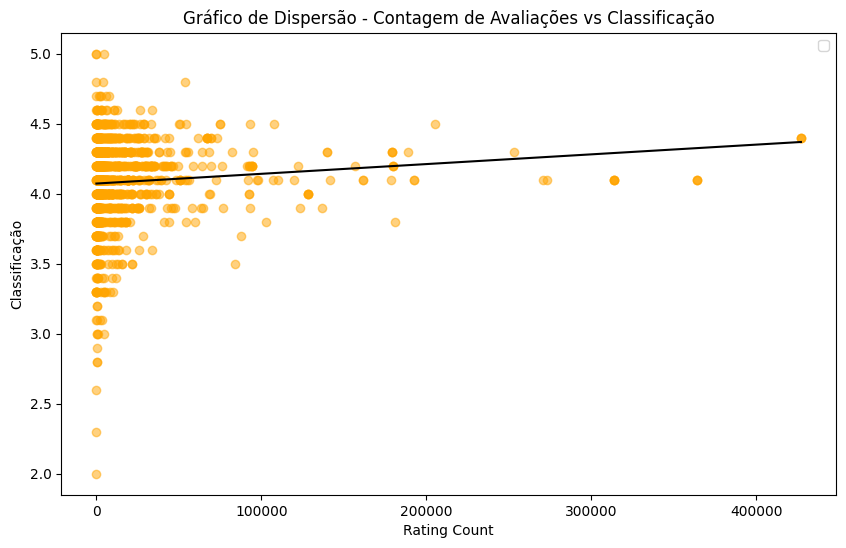

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT rating_count, rating
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query
query_job = client.query(query)
results = query_job.result()

# DataFrame
df = pd.DataFrame([dict(row) for row in results])

# Converter para numérico e verificar valores não numéricos
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')

# Remover linhas com valores ausentes
df = df.dropna(subset=['rating_count', 'rating'])

# Verificar se há valores não numéricos ou inconsistências
print(df.info())  # Para verificar os tipos de dados
print(df.head())  # Para visualizar uma amostra dos dados

# Selecionar as variáveis independentes (X) e dependente (y)
X = df[['rating_count']]  # Variável independente
y = df['rating']  # Variável dependente

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Adicionar uma constante ao X (intercepto) para statsmodels
X_train_sm = sm.add_constant(X_train)

# Ajustar o modelo de regressão linear com statsmodels
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Printar o sumário do modelo
print(model_sm.summary())

# Gerar previsões para o conjunto de teste
X_test_sm = sm.add_constant(X_test)
y_pred = model_sm.predict(X_test_sm)

# Calcular e imprimir o erro quadrático médio
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plotar o gráfico de dispersão e a linha de regressão
plt.figure(figsize=(10, 6))

# Gráfico de dispersão
plt.scatter(df['rating_count'], df['rating'], alpha=0.5, color='orange')

# Criar um intervalo de valores de rating_count para a linha de regressão
x_range = np.linspace(df['rating_count'].min(), df['rating_count'].max(), 100).reshape(-1, 1)
x_range_sm = sm.add_constant(x_range)  # Adicionar constante
y_range = model_sm.predict(x_range_sm)  # Previsões para a linha de regressão

plt.plot(x_range, y_range, color='black')

plt.title('Gráfico de Dispersão - Contagem de Avaliações vs Classificação')
plt.xlabel('Rating Count')
plt.ylabel('Classificação')
plt.legend()
plt.show()


#Regressão Logística

Regressão Logistica

rating_dummy
0    171
1    100
Name: count, dtype: int64


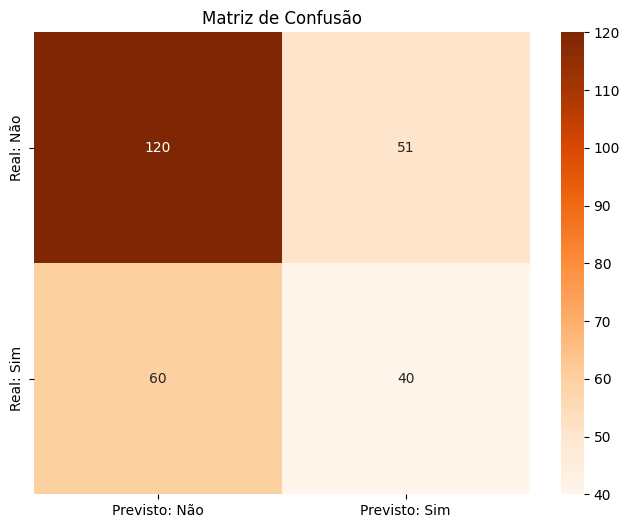

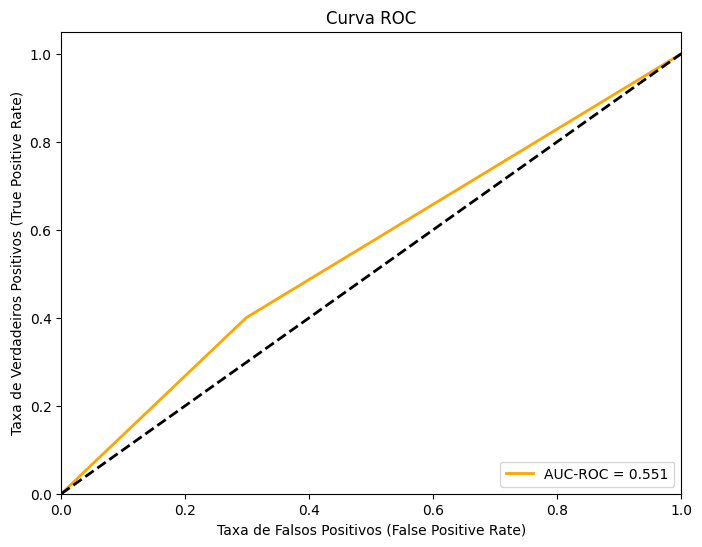

Regressão Logística:
[[120  51]
 [ 60  40]]

Métricas de Avaliação:
Exatidão (Accuracy): 0.590
Precisão: 0.440
Sensibilidade (Recall): 0.400
F1-score: 0.419
AUC-ROC: 0.551
Log-Loss: 0.687
Acurácia no conjunto de treino: 0.585
Acurácia no conjunto de teste: 0.590


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, log_loss, roc_curve
from google.colab import auth
from google.cloud import bigquery

# Autenticar e configurar o cliente BigQuery
auth.authenticate_user()
project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

# Consulta SQL para selecionar img_link_dummy e rating
query = """
SELECT img_link_dummy, rating
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a consulta
query_job = client.query(query)
results = query_job.result()

# DataFrame
df = pd.DataFrame([dict(row) for row in results])

# Converter a coluna 'rating' para numérico e lidar com valores não numéricos
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Remover linhas com valores ausentes
df = df.dropna(subset=['rating'])

# Criar a variável dummy para a classificação (ajustado conforme o critério fornecido)
df['rating_dummy'] = df['rating'].apply(lambda x: 0 if x > 4 else 1)

# Separar as características (X) e a variável dependente (y)
X = df[['img_link_dummy']]  # Característica: se o produto tem imagem ou não
y = df['rating_dummy']  # Variável dependente: 0 (rating > 4) ou 1 (rating <= 4)

# Dividir os dados em conjunto de treino e teste, estratificando por 'rating_dummy'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Verificar a distribuição das classes no conjunto de teste
print(y_test.value_counts())

# Estandarizar as características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Criar o modelo de regressão logística
model = LogisticRegression(class_weight='balanced')

# Treinar o modelo
model.fit(X_train, y_train)

# Realizar predições no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calcular métricas de avaliação
tn, fp, fn, tp = conf_matrix.ravel()
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

# Calcular AUC-ROC e Log-Loss
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
log_loss_value = log_loss(y_test, model.predict_proba(X_test))

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

# Calcular e exibir a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Previsto: Não', 'Previsto: Sim'], yticklabels=['Real: Não', 'Real: Sim'])
plt.title('Matriz de Confusão')
plt.show()

# Visualização da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC-ROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Imprimir resultados
print("\033[1mRegressão Logística:\033[0m")
print(conf_matrix)

print("\n\033[1mMétricas de Avaliação:\033[0m")
print(f"Exatidão (Accuracy): {accuracy:.3f}")
print(f"Precisão: {precision:.3f}")
print(f"Sensibilidade (Recall): {sensitivity:.3f}")
print(f"F1-score: {f1_score:.3f}")
print(f"AUC-ROC: {roc_auc:.3f}")
print(f"Log-Loss: {log_loss_value:.3f}")

# Avaliar o modelo nos dados de treino e teste
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Acurácia no conjunto de treino: {train_accuracy:.3f}')
print(f'Acurácia no conjunto de teste: {test_accuracy:.3f}')


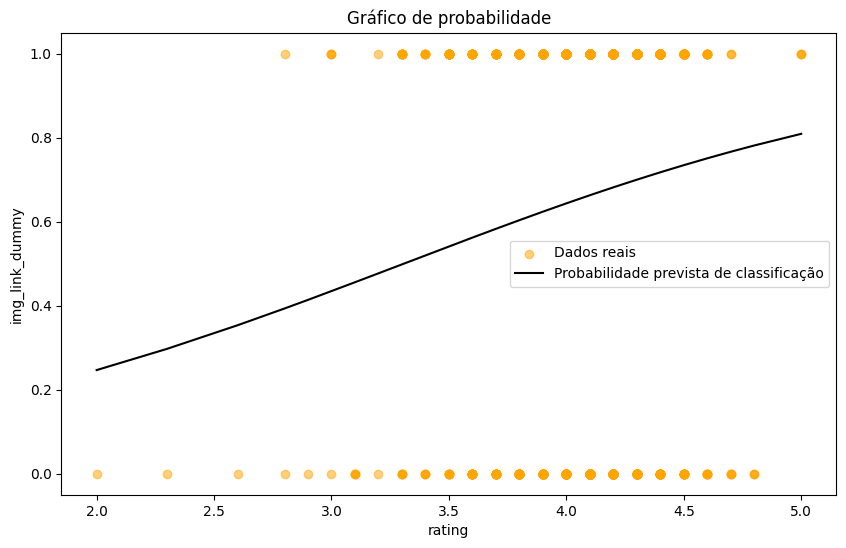

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

auth.authenticate_user()

project_id = "datalab-amazon-produtos"
client = bigquery.Client(project=project_id)

query = """
SELECT img_link_dummy, rating
FROM `datalab-amazon-produtos.amazon_sales.amazon_completa`
"""

# Executar a query
query_job = client.query(query)
results = query_job.result()

df = pd.read_gbq(query, project_id=project_id, dialect="standard")

# Convert 'rating' column to numeric, handling non-numeric values
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Drop rows with missing values in 'rating'
df = df.dropna(subset=['rating'])

# Modelo de regressão logística
logistic_model = LogisticRegression()
logistic_model.fit(df[['rating']], df['img_link_dummy'])

probabilities = logistic_model.predict_proba(df[['rating']])[:, 1]

# Plotando o gráfico de dispersão
plt.figure(figsize=(10, 6))

# Pontos de dados reais
plt.scatter(df['rating'], df['img_link_dummy'], alpha=0.5, color='orange', label='Dados reais')

# Adicionando a curva de probabilidade da regressão logística
sorted_indices = np.argsort(df['rating'])
sorted_score_dummy = df['rating'].iloc[sorted_indices]
sorted_probabilities = probabilities[sorted_indices]
plt.plot(sorted_score_dummy, sorted_probabilities, color='black', label='Probabilidade prevista de classificação')

# Títulos e rótulos
plt.title('Gráfico de probabilidade')
plt.xlabel('rating')
plt.ylabel('img_link_dummy')
plt.legend()

plt.show()